In [ ]:
# default_exp 
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Diffusion Maps on Manifolds with Flow


We begin from the "Manifold with Flow" hypothesis: we are given data $X$ and vectors $v_i$ associated with each point $x_i$. We want to learn an embedding $\phi$ of $X$ which respects $V$, such that the euclidean distances in the embedding $\phi(X)$ indicate the difficulty of travelling from $i$ to $j$ along with the vector field.

The ML Group's initial approach involved trying to *create* a geometry in the embedding space which obeyed the asymmetry inherent in directional flows and directed graphs. Motivated by this, we built networks to learn a flow field in the embedding space, such that the t-step transition probabilities obtained via a flow-weighted "flashlight" kernel replicated the transition probabilities of the directed graph (or manifold with a vector field).

This approach has promise for 2 or 3 dimension visualization (where using a grid to allow the flow to influence the embedding geometry is tractable). But for *inference* problems, a different approach is needed: one which focuses less on the flow, and more on mapping the flow relationships into euclidean space in a way which preserves as much information as possible in the symmetric confines of euclidean space. 

To this end, we introduce a small refinement to the diffusion map -- one which attempts to make the diffusion map embed points in a manner which respects the flows between the points. One side of this question is a priori impossible; if a flows to b, we cannot indicate this by placement in euclidean space, except by drawing an arrow from a pointing towards b. But we can indicate by euclidean distance whether or not a pair of points is *reachable* by flow, in either direction. Specifically, if a flows to b, a and b should be close (with an arrow to indicate direction). But if a doesn't flow to c, and c doesn't flow to a, then a and c should be far away in euclidean space.

We can encode this relationship in the diffusion map by changing the input. Diffusion maps don't work on asymmetric affinity matrices, as they are no longer guaranteed to have real eigenvectors (or any  eigenvectors, for that matter). But we can *symmetrize* the asymmetric flow-based affinity matrix, by taking $A + A^T$. In this construction, there is high affinity between i and j iff i flows to j or j flows to i, with low affinity iff neither point flows to the other.

Here we explore this idea, to determine whether this symmetrization yields a good diffusion map, which is more informative than the diffusion mapping of a euclidean-based affinity matrix which ignores the flows.

For our dataset, we will use a *branch* with flow extending down the trunk and off the 'branches'. We expect the base diffusion map to recreate the branch with each of its branches in different dimensions, but no particular care to place the branches far away from each other. Introducing the flow-based affinity matrix should, we expect, lead the branches to separate more forcefully in the embedding space.

Here's our branch. Note the arrows leaving the baby blue and sun-colored branches.

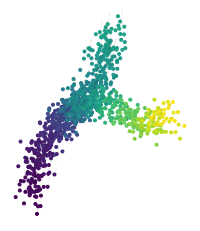

In [ ]:
from FRED.datasets import directed_sinh_branch, plot_directed_2d
X, flow, labels = directed_sinh_branch(num_nodes=1000, xscale=10, yscale=8, sigma=5)
plot_directed_2d(X, flow, labels,minimal=True)

First, let's verify that the diffusion map of the branch makes sense. It might be that the diffusion distances between the branches are already maxed out at 1. It is also possible that a 2 dimensional embedding will fail to capture the relationship.

In [ ]:
from FRED.data_processing import diffusion_map_from_points, diffusion_map_from_affinities, adaptive_anisotropic_kernel
D = FRED.data_processing.distance_matrix(X)
W_normal= adaptive_anisotropic_kernel(D,k=10)
dmap = diffusion_map_from_points(X, k=40, t=1)

using sigma =  8.5762914750587


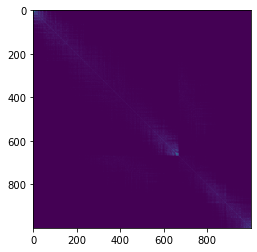

In [ ]:
plt.imshow(W_normal)

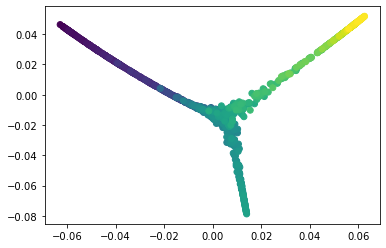

In [ ]:
plt.scatter(dmap[:,0],dmap[:,1], c = labels)

Thankfully, the diffusion map (in the first two dimensions) does include all of the branches. I was worried. They even overlap in strange ways which, one would hope, could be resolved by introducing flow.

First, we'll do an affinity grid search to find the right matrix construction for this dataset.

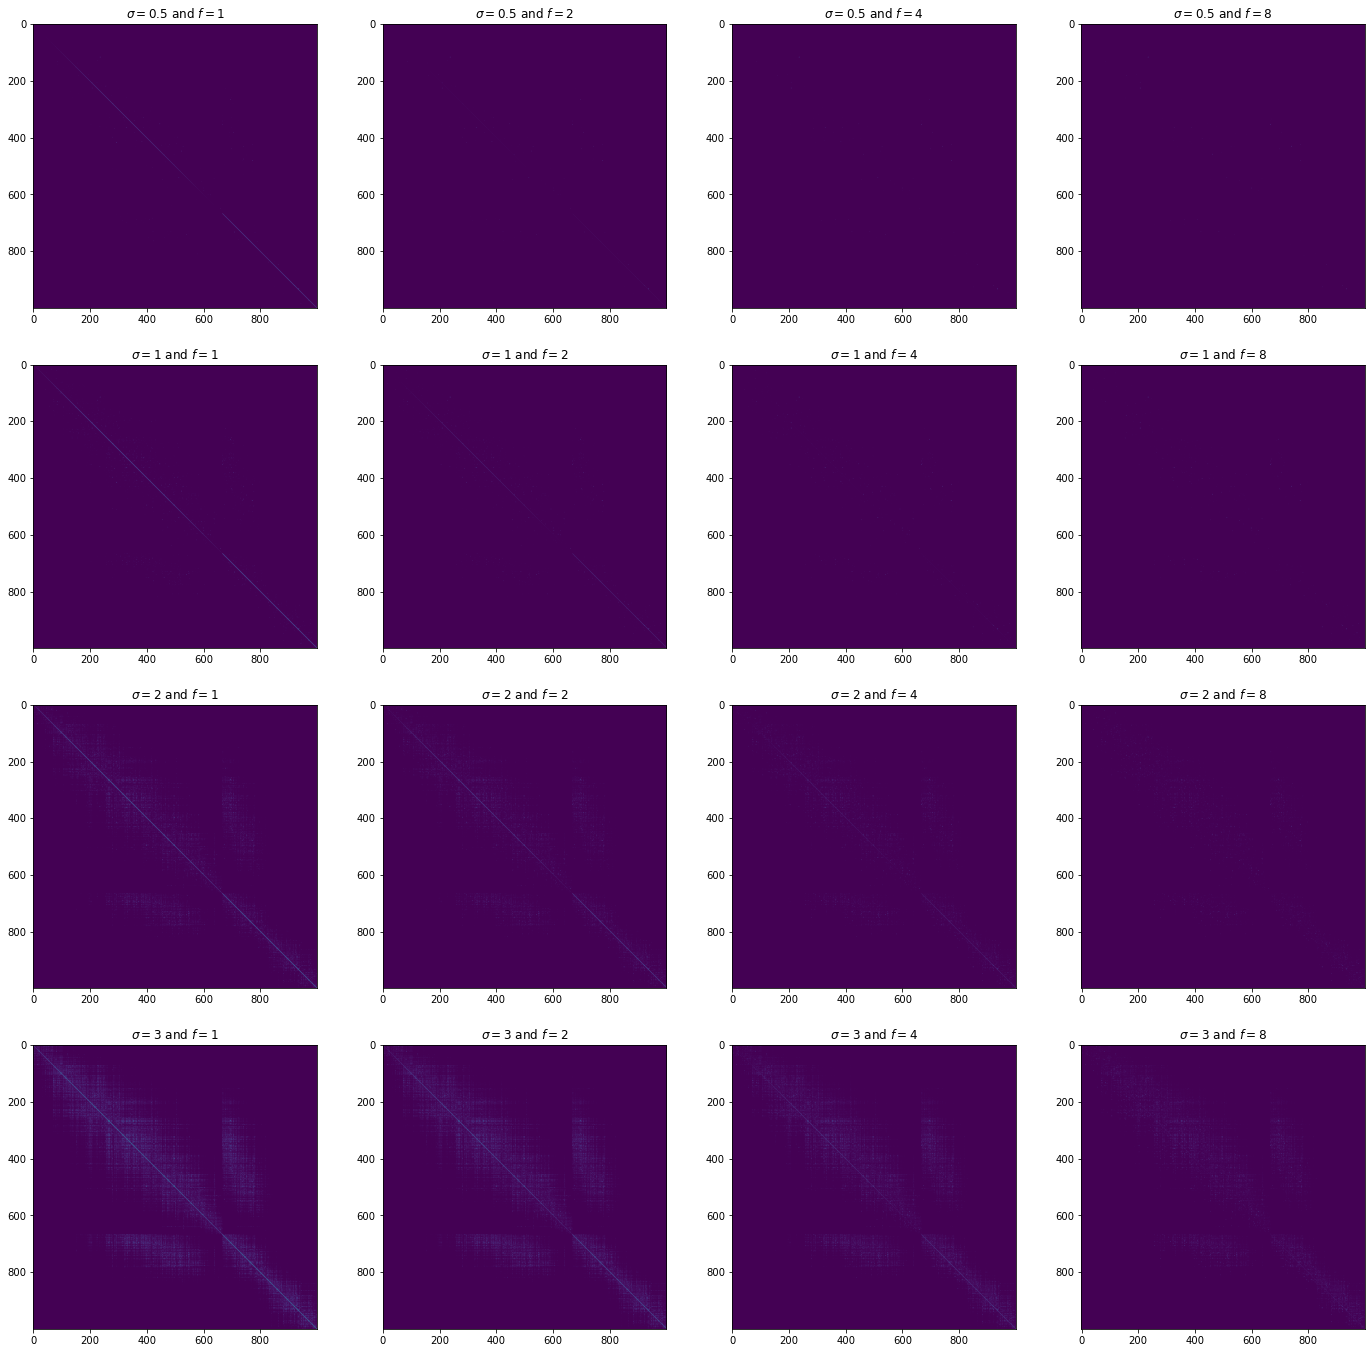

In [ ]:
from FRED.data_processing import affinity_grid_search
X_torch = torch.tensor(X)
flow = torch.tensor(flow)
affinity_grid_search(X_torch,flow, sigmas = [0.5, 1, 2, 3], flow_strengths = [1, 2, 4, 8])

1 and 1 appears to work perfectly well.

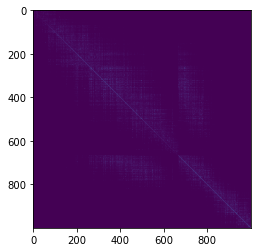

In [ ]:
from FRED.data_processing import affinity_matrix_from_pointset_to_pointset
A_flow = affinity_matrix_from_pointset_to_pointset(X_torch, X_torch, flow, sigma=3, flow_strength = 3)
plt.imshow(A_flow)

And now to symmetrize this. We expect there to be high affinity from the root of the branch to the end branches. 

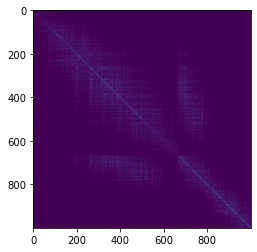

In [ ]:
A_symmetric_flow = A_flow + A_flow.T
plt.imshow(A_symmetric_flow)

[0.79433673+0.j 0.82201842+0.j 0.84004911+0.j 0.92018851+0.j
 0.98155091+0.j]


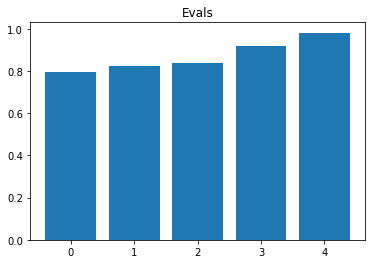

In [ ]:
dmap = diffusion_map_from_affinities(A_symmetric_flow,t=1,plot_evals=True)

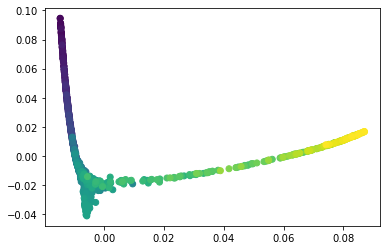

In [ ]:
plt.scatter(dmap[:,0],dmap[:,1],c=labels)

Huzzah! The branches in this diffusion map are much straighter, and the two branches are further apart. The experiment appears to be a success.